# NFL Verse Analysis
This notebook was created to analyze injuries on the NFL Verse datasets. Multiple datasets were used to analyze the injuries of players in the NFL. The datasets include:
- injuries data
- play-by-play data
- schedule data

This first section is amied to load the datasets for the first time from the NFL Verse API. We used the nflverse python package to load the datasets.

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nfl_data_py as nfl
import seaborn as sns

In [197]:
# # Run only once to download the data then commment out.
# years = range(2010, 2024)

# # Get the injury data
# injuries = nfl.import_injuries(years)

In [198]:
# injuries.head()

Get more datatets to combine with injuries.

In [199]:
# # Get the play-by-play data
# pbp = nfl.import_pbp_data(years, downcast=True, cache=False, alt_path=None)

# # Schedule
# s = nfl.import_schedules(years)

Store the data for future reference, and not have to re-download it.

In [200]:
# injuries.to_csv('../data/raw/NFL_verse_injuries.csv', index=False)
# pbp.to_csv('../data/raw/NFL_verse_pbp.csv', index=False)
# s.to_csv('../data/raw/NFL_verse_schedule.csv', index=False)

RUN ONLY IF DATA ALREADY EXISTS

In [201]:
injuries = pd.read_csv('../data/raw/NFL_verse_injuries.csv')
pbp = pd.read_csv('../data/raw/NFL_verse_pbp_data.csv')
s = pd.read_csv('../data/raw/NFL_verse_schedules.csv')

/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_55120/1951509686.py:2: DtypeWarning: Columns (45,179,180,182,183,189,190,193,194,195,196,197,198,203,204,205,206,209,210,213,214,218,219,220,222,224,226,233,234,235,236,237,238,243,244,245,248,249,253,254,255,260,262,263,266,267,268,269,277,283,284,302,332,372,373,374,375,377,379,380,381,386,387,388,389) have mixed types. Specify dtype option on import or set low_memory=False.
  pbp = pd.read_csv('../data/raw/NFL_verse_pbp_data.csv')


In [202]:
print(f"Injuries has {injuries.shape[0]} rows and {injuries.shape[1]} columns")
print(f"PBP has {pbp.shape[0]} rows and {pbp.shape[1]} columns")
print(f"Schedule has {s.shape[0]} rows and {s.shape[1]} columns")

Injuries has 79863 rows and 16 columns
PBP has 672072 rows and 390 columns
Schedule has 3793 rows and 46 columns


Create a dict of schedule to create the game_id in the injuries data.

In [203]:
s[['season', 'week', 'home_team', 'away_team', 'game_id']].head()

,season,week,home_team,away_team,game_id
0,2010,1,NO,MIN,2010_01_MIN_NO
1,2010,1,BUF,MIA,2010_01_MIA_BUF
2,2010,1,CHI,DET,2010_01_DET_CHI
3,2010,1,HOU,IND,2010_01_IND_HOU
4,2010,1,JAX,DEN,2010_01_DEN_JAX


Run only once to get the game_id for each injury

In [204]:
# # Create a dict of schedule to create the game_id in the injuries data, get the year, week, home and away team
# schedule_dict = {}

# for index, row in s.iterrows():
#   schedule_dict[row['game_id']] = {
#     'season': row['season'],
#     'week': row['week'],
#     'home_team': row['home_team'],
#     'away_team': row['away_team']
#   }

# # The injury data does not have game_id, so we need to create it using the schedule data
# # It only has season, week, and the team that the player played for
# injuries['game_id'] = 'unknown'  # Initialize game_id column

# for index, row in injuries.iterrows():
#   for game_id, game_info in schedule_dict.items():
#     if (game_info['season'] == row['season'] and
#       game_info['week'] == row['week'] and
#       (game_info['home_team'] == row['team'] or game_info['away_team'] == row['team'])):
#       row['game_id'] = game_id
#       break  # Stop searching once a match is found
#   injuries.loc[index, 'game_id'] = row['game_id']


In [205]:
# injuries.to_csv('../data/processed/NFL_verse_injuries_with_game_id.csv', index=False)

ONLY AFTER RUNNING THE ABOVE CODE ONCE

In [206]:
injuries = pd.read_csv('../data/processed/NFL_verse_injuries_with_game_id.csv', low_memory=False)

## Cleaning the data

### Clean the injuries data

Rename columns and select only the columns we need.

In [207]:
injuries_renamed = injuries.rename(columns={
    'gsis_id': 'player_id',
    'report_primary_injury': 'injury_body_part',
    'report_status': 'severity'
})[['game_id', 'player_id', 'injury_body_part', 'severity', 'position']]

injuries_renamed['injury_body_part'] = injuries_renamed['injury_body_part'].str.lower()
len(injuries_renamed)

79863

In [208]:
# If there are more than 2 injuries for the same player in the same game, we will keep the first one
injuries_renamed_no_dups = injuries_renamed.groupby(['game_id', 'player_id']).first().reset_index()
injuries_renamed_no_dups.head()

,game_id,player_id,injury_body_part,severity,position
0,2010_01_ARI_STL,00-0013126,back,Probable,LB
1,2010_01_ARI_STL,00-0022288,toe,Questionable,RB
2,2010_01_ARI_STL,00-0022921,knee,Probable,WR
3,2010_01_ARI_STL,00-0023053,knee,Probable,S
4,2010_01_ARI_STL,00-0025602,knee,Probable,TE


In [209]:
injuries_value_count = injuries_renamed_no_dups['injury_body_part'].value_counts()
print(injuries_value_count.head(10))

# Drop where injuries is illness or contains illness
injuries_renamed_no_illness = injuries_renamed[~injuries_renamed['injury_body_part'].str.contains('illness', na=False)]
injuries_value_count_no_illness = injuries_renamed_no_illness['injury_body_part'].value_counts()
print(injuries_value_count_no_illness.head(10))

injury_body_part
knee          9214
ankle         7400
hamstring     5462
shoulder      3768
concussion    2606
foot          2549
groin         2297
back          2100
calf          1635
illness       1544
Name: count, dtype: int64
injury_body_part
knee          9556
ankle         7673
hamstring     5665
shoulder      3864
concussion    2693
foot          2622
groin         2390
back          2147
calf          1703
hip           1426
Name: count, dtype: int64


In [210]:
# Get a dict of injury body parts
injuries_renamed_no_illness['injury_body_part'].unique()

array(['knee', 'toe', 'shoulder', 'back', 'hip', 'foot', 'head',
       'hamstring', 'chest', 'groin', 'ankle', nan, 'forearm', 'finger',
       'abdomen', 'calf', 'eye', 'thumb', 'neck', 'thigh',
       'right shoulder', 'kidney', 'not injury related', 'elbow',
       'achilles', 'lacerated kidney', 'fibula', 'concussion',
       'right thumb', 'hand', 'rib', 'biceps', 'wrist', 'oblique',
       'left hamstring', 'quadricep', 'stinger', '(migraines)', 'heel',
       'ribs', 'arch', 'right elbow', 'shin', 'migraines', 'pelvis',
       'collarbone', 'right hip', 'glute', 'right calf', 'tibia',
       'left calf', 'nose', 'left ankle', 'right hamstring',
       'right groin', 'right finger', 'left shoulder', 'left forearm',
       'triceps', 'qblique', 'quad', 'right ankle', 'pectoral',
       'right knee', 'arm', 'left wrist', 'lower leg', 'lf. calf',
       'infection', 'knees', 'l. arm', 'tricep', 'flu', 'right foot',
       'right wrist', 'feet', 'left foot', 'right hand', 'left fing

In [211]:
contains_to_drop = ['not injur', 'returning', 'protocol', 'personal', 'coach', '-', '/', 'ill', ',', 'inactive', 'football', 'covid', 'migraine', 'infection', 'breath', 'append', 'other', 'liver', 'flu', 'stinger', 'spleen', 'hernia']

# Drop the values that are in the list
for value in contains_to_drop:
    injuries_renamed_no_illness = injuries_renamed_no_illness[~injuries_renamed_no_illness['injury_body_part'].str.contains(value, na=False)]

injuries_renamed_no_illness['injury_body_part'].unique()

array(['knee', 'toe', 'shoulder', 'back', 'hip', 'foot', 'head',
       'hamstring', 'chest', 'groin', 'ankle', nan, 'forearm', 'finger',
       'abdomen', 'calf', 'eye', 'thumb', 'neck', 'thigh',
       'right shoulder', 'kidney', 'elbow', 'lacerated kidney', 'fibula',
       'concussion', 'right thumb', 'hand', 'rib', 'biceps', 'wrist',
       'oblique', 'left hamstring', 'quadricep', 'heel', 'ribs', 'arch',
       'right elbow', 'shin', 'pelvis', 'collarbone', 'right hip',
       'glute', 'right calf', 'tibia', 'left calf', 'nose', 'left ankle',
       'right hamstring', 'right groin', 'right finger', 'left shoulder',
       'left forearm', 'triceps', 'qblique', 'quad', 'right ankle',
       'pectoral', 'right knee', 'arm', 'left wrist', 'lower leg',
       'lf. calf', 'knees', 'l. arm', 'tricep', 'right foot',
       'right wrist', 'feet', 'left foot', 'right hand', 'left finger',
       'low back', 'left thumb', 'right thigh', 'leg', 'hips',
       'left thigh', 'right quadricep',

In [212]:
# Create a mapping dict for the injury body parts
injury_mapping = {
    'right shoulder': 'shoulder', 'left shoulder': 'shoulder', 'shoulders': 'shoulder',
    'right thumb': 'thumb', 'left thumb': 'thumb',
    'right hamstring': 'hamstring', 'left hamstring': 'hamstring', 'hamstrings': 'hamstring',
    'right groin': 'groin', 'left groin': 'groin',
    'right knee': 'knee', 'left knee': 'knee', 'knees': 'knee', 'both knees': 'knee',
    'right ankle': 'ankle', 'left ankle': 'ankle', 'ankles': 'ankle',
    'right foot': 'foot', 'left foot': 'foot', 'feet': 'foot',
    'right wrist': 'wrist', 'left wrist': 'wrist',
    'right hand': 'hand', 'left hand': 'hand', 'hands': 'hand',
    'right finger': 'finger', 'left finger': 'finger',
    'right elbow': 'elbow', 'left elbow': 'elbow',
    'right forearm': 'forearm', 'left forearm': 'forearm',
    'right calf': 'calf', 'left calf': 'calf', 'lf. calf': 'calf',
    'right quadricep': 'quadricep', 'left quadricep': 'quadricep', 'quadriceps': 'quadricep',
    'right thigh': 'thigh', 'left thigh': 'thigh',
    'right shin': 'shin',
    'right collarbone': 'collarbone',
    'right biceps': 'biceps', 'bicep': 'biceps',
    'tricep': 'triceps',
    'oblique ': 'oblique', 'qblique': 'oblique',
    'pectoral': 'chest',
    'abdominal': 'abdomen',
    'core muscle': 'core', 'core muscle injury': 'core',
    'rib cage': 'rib',
    'rib': 'ribs',
    'lumbar': 'lower back', 'low back': 'lower back',
    'heat cramps': 'unknown',
    'facial laceration': 'face', 'facial lacerations': 'face',
    'teeth': 'tooth',
    'lung contusion': 'lung',
    'arrhythmia': 'cardiac',
    'sternoclavicular': 'collarbone',
    'hip flexor': 'hip', 'left hip': 'hip', 'right hip':'hip', 'hips': 'hip', 'buttocks': 'hip',
    'solar plexus': 'abdomen',
    'tailbone': 'lower back',
    'trapezius': 'shoulder',
    'lacerated kidney': 'kidney',
    'rt. thumb': 'thumb',
    'l. arm': 'arm',
    'lacerated kidney': 'kidney',
    'lower back': 'back',
    'right upper arm': 'arm', 'upper arm': 'arm'
}

# Apply cleaning function
def clean_injury(value):
    if pd.isna(value):
        return "unknown"
    value = value.strip().lower()  # Remove extra spaces and lowercase
    return injury_mapping.get(value, value)  # Replace if in mapping, otherwise keep as is

# Apply cleaning
injuries_renamed_cleaned = injuries_renamed_no_illness.copy()
injuries_renamed_cleaned['injury_body_part'] = injuries_renamed_no_illness['injury_body_part'].apply(clean_injury)
injuries_renamed_cleaned['injury_body_part'].unique()

array(['knee', 'toe', 'shoulder', 'back', 'hip', 'foot', 'head',
       'hamstring', 'chest', 'groin', 'ankle', 'unknown', 'forearm',
       'finger', 'abdomen', 'calf', 'eye', 'thumb', 'neck', 'thigh',
       'kidney', 'elbow', 'fibula', 'concussion', 'hand', 'ribs',
       'biceps', 'wrist', 'oblique', 'quadricep', 'heel', 'arch', 'shin',
       'pelvis', 'collarbone', 'glute', 'tibia', 'nose', 'triceps',
       'quad', 'arm', 'lower leg', 'lower back', 'leg', 'stomach', 'jaw',
       'face', 'ear', 'cardiac', 'tooth', 'throat', 'lung', 'chin',
       'toes', 'rib', 'core', 'mouth', 'adductor'], dtype=object)

In [213]:
# drop where injury body part is unknown
injuries_cleaned = injuries_renamed_cleaned[injuries_renamed_cleaned['injury_body_part'] != 'unknown']

Relevant columns for pass or rush plays

In [214]:
relevant_columns = [
    # Play Identification & Context
    "play_id", "game_id", "week", "season", "away_team", "home_team",
    "quarter_seconds_remaining", "half_seconds_remaining", "game_seconds_remaining",
    "qtr", "down", "ydstogo", "yardline_100", "score_differential",

    # Play Type & Execution
    "play_type", "rush_attempt", "pass_attempt", "sack", 
    "incomplete_pass", "qb_scramble", "shotgun", "no_huddle",

    # Passing Attributes
    "qb_dropback", "pass_length", "pass_location", "air_yards", 
    "yards_after_catch", "passing_yards", "passer_player_id", "passer_player_name",
    "receiver_player_id", "receiver_player_name", "complete_pass",

    # Rushing Attributes
    "run_location", "run_gap", "rushing_yards", "rusher_player_id", "rusher_player_name",

    # Outcome Metrics
    "yards_gained", "epa", "air_epa", "yac_epa",
    "rush_touchdown", "pass_touchdown", "first_down_rush", "first_down_pass"
]

pbp_relevant = pbp[relevant_columns]


In [215]:
pbp_relevant = pbp_relevant[(pbp_relevant['play_type'].isin(['run','pass']))]

In [216]:
# # Iterate through the pbp data and see if the injured player is in the play, if so, add the injury
# # boolean, the body part and the injury type to the play data
# pbp_relevant['injury'] = False
# pbp_relevant['injury_body_part'] = 'No injury'
# pbp_relevant['severity'] = 'No injury'

# for inj_index, inj_row in injuries.iterrows():
#   for pbp_index, pbp_row in pbp_relevant.iterrows():
#     if (pbp_row['game_id'] == inj_row['game_id']):
#       if (pbp_row['passer_player_id'] == inj_row['gsis_id']):
#         pbp_relevant.loc[pbp_index, 'injury'] = True
#         pbp_relevant.loc[pbp_index, 'injury_body_part'] = inj_row['report_primary_injury']
#         pbp_relevant.loc[pbp_index, 'severity'] = inj_row['report_status']
#         break
#       elif (pbp_row['receiver_player_id'] == inj_row['gsis_id']):
#         pbp_relevant.loc[pbp_index, 'injury'] = True
#         pbp_relevant.loc[pbp_index, 'injury_body_part'] = inj_row['report_primary_injury']
#         pbp_relevant.loc[pbp_index, 'severity'] = inj_row['report_status']
#         break
#       elif (pbp_row['rusher_player_id'] == inj_row['gsis_id']):
#         pbp_relevant.loc[pbp_index, 'injury'] = True
#         pbp_relevant.loc[pbp_index, 'injury_body_part'] = inj_row['report_primary_injury']
#         pbp_relevant.loc[pbp_index, 'severity'] = inj_row['report_status']
#         break

Now we need to merge the dataframes to get the stats for each game such as weather and field type

In [217]:
# Step 2: Reshape `pbp` to match `injuries` structure
pbp_long = pbp_relevant.melt(
    id_vars=['game_id'], 
    value_vars=['passer_player_id', 'receiver_player_id', 'rusher_player_id'], 
    var_name='role', 
    value_name='player_id'
)

# Step 3: Merge injuries with play-by-play data
pbp_long = pbp_long.merge(injuries_cleaned, on=['game_id', 'player_id'], how='left')

# Step 4: Fill missing injury data
pbp_long['injury'] = pbp_long['injury_body_part'].notna()
pbp_long.fillna({'injury_body_part': 'No injury', 'severity': 'No injury'}, inplace=True)

# Step 5: Pivot back to wide format
pbp_pivot = pbp_long.pivot_table(
    index=['game_id'], 
    columns='role', 
    values=['injury_body_part', 'severity'], 
    aggfunc='first'  # Take the first non-null injury entry
)
pbp_pivot.columns = ['_'.join(col).replace('_player_id', '') for col in pbp_pivot.columns]  # Flatten column names
pbp_pivot.reset_index(inplace=True)

# Step 6: Merge back into `pbp`
pbp_relevant = pbp_relevant.merge(pbp_pivot, on='game_id', how='left')

# Step 7: Create a final injury flag
pbp_relevant['injury'] = pbp_relevant[['injury_body_part_passer', 'injury_body_part_receiver', 'injury_body_part_rusher']].apply(
    lambda row: any(x != 'No injury' for x in row), axis=1
)

# Step 8: Leave only one injury part for each play
pbp_relevant['final_injury_part'] = pbp_relevant[['injury_body_part_passer', 'injury_body_part_receiver', 'injury_body_part_rusher']].bfill(axis=1).iloc[:, 0]
pbp_relevant['severity'] = pbp_relevant[['severity_passer', 'severity_receiver', 'severity_rusher']].bfill(axis=1).iloc[:, 0]

In [218]:
print(pbp_relevant['final_injury_part'].value_counts(), '\n')
print(pbp_relevant['injury'].value_counts())

final_injury_part
No injury     462300
shoulder        3175
knee            1630
ankle           1470
foot            1178
elbow           1038
finger          1009
back             766
quadricep        736
hand             644
thumb            636
hamstring        523
chest            490
ribs             484
calf             389
wrist            271
abdomen          263
groin            257
concussion       247
thigh            244
head             129
toe              124
hip              118
Name: count, dtype: int64 

injury
False    408875
True      69246
Name: count, dtype: int64


### Clean the schedule data before merging

In [219]:
s['surface'].value_counts()

surface
grass         2043
fieldturf      964
sportturf      236
matrixturf     169
astroturf      100
grass           93
a_turf          91
astroplay       56
Name: count, dtype: int64

In [220]:
# There are too many surfaces, we will combine them into 2 categories either grass or turf
s['surface'].replace('a_turf','fieldturf',inplace=True)
s['surface'].replace('astroplay','fieldturf',inplace=True)
s['surface'].replace('sportturf','fieldturf',inplace=True)
s['surface'].replace('matrixturf','fieldturf',inplace=True)
s['surface'].replace('astroturf','fieldturf',inplace=True)
s['surface'].replace('grass ','grass',inplace=True)
s['surface'].value_counts()

/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_55120/535587010.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  s['surface'].replace('a_turf','fieldturf',inplace=True)
/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_55120/535587010.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values

surface
grass        2136
fieldturf    1616
Name: count, dtype: int64

In [221]:
print(s['surface'].isnull().sum())

41


In [222]:
# There are quite some values, we will cretate a map for the stadiums and their surfaces

# Create a dict for the stadiums and their surfaces with the values in the dataset
# Get the values from the dataset
stadium_surface = s[['stadium', 'surface']].drop_duplicates()
stadium_surface = stadium_surface[stadium_surface['surface'].notnull()]
stadium_surface = stadium_surface.set_index('stadium')['surface'].to_dict()
print("Stadium-Surface Mapping:", stadium_surface)

Stadium-Surface Mapping: {'Louisiana Superdome': 'fieldturf', 'Ralph Wilson Stadium': 'fieldturf', 'Soldier Field': 'grass', 'Reliant Stadium': 'grass', 'EverBank Field': 'grass', 'Gillette Stadium': 'grass', 'New Meadowlands Stadium': 'fieldturf', 'Heinz Field': 'grass', 'Raymond James Stadium': 'grass', 'LP Field': 'grass', 'Lincoln Financial Field': 'grass', 'Qwest Field': 'fieldturf', 'Edward Jones Dome': 'fieldturf', 'FedExField': 'grass', 'Arrowhead Stadium': 'fieldturf', 'Georgia Dome': 'fieldturf', 'Bank of America Stadium': 'grass', 'Paul Brown Stadium': 'grass', 'Cleveland Browns Stadium': 'grass', 'Cowboys Stadium': 'grass', 'Ford Field': 'fieldturf', 'Lambeau Field': 'grass', 'Mall of America Field': 'fieldturf', 'Invesco Field at Mile High': 'grass', 'Oakland-Alameda County Coliseum': 'grass', 'Qualcomm Stadium': 'grass', 'Lucas Oil Stadium': 'fieldturf', 'Candlestick Park': 'grass', 'M&T Bank Stadium': 'grass', 'University of Phoenix Stadium': 'grass', 'Sun Life Stadium':

In [223]:
# Now we can use this dict to fill the missing values in the dataset
s['surface'].fillna(s['stadium'].map(stadium_surface), inplace=True)
# Check if there are any missing values
print(s['surface'].isnull().sum())

1


/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_55120/983890332.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  s['surface'].fillna(s['stadium'].map(stadium_surface), inplace=True)


In [224]:
combined_data = pd.merge(pbp_relevant,s,on=['game_id','week','home_team','away_team'],how='left')

In [225]:
# Print the columns to decide which ones to keep
print(combined_data.columns)

Index(['play_id', 'game_id', 'week', 'season_x', 'away_team', 'home_team',
       'quarter_seconds_remaining', 'half_seconds_remaining',
       'game_seconds_remaining', 'qtr', 'down', 'ydstogo', 'yardline_100',
       'score_differential', 'play_type', 'rush_attempt', 'pass_attempt',
       'sack', 'incomplete_pass', 'qb_scramble', 'shotgun', 'no_huddle',
       'qb_dropback', 'pass_length', 'pass_location', 'air_yards',
       'yards_after_catch', 'passing_yards', 'passer_player_id',
       'passer_player_name', 'receiver_player_id', 'receiver_player_name',
       'complete_pass', 'run_location', 'run_gap', 'rushing_yards',
       'rusher_player_id', 'rusher_player_name', 'yards_gained', 'epa',
       'air_epa', 'yac_epa', 'rush_touchdown', 'pass_touchdown',
       'first_down_rush', 'first_down_pass', 'injury_body_part_passer',
       'injury_body_part_receiver', 'injury_body_part_rusher',
       'severity_passer', 'severity_receiver', 'severity_rusher', 'injury',
       'final_inju

## Plotting the data

/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_55120/672084391.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=injuries_total.index, y=injuries_total.values, palette='viridis')


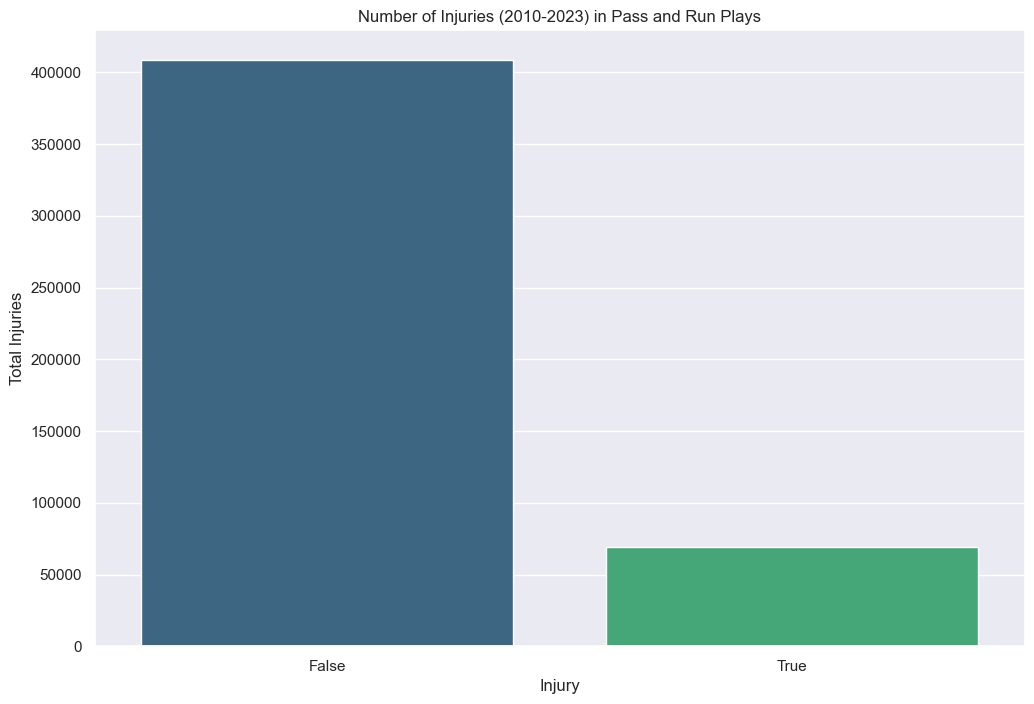

In [227]:
# Injuries vs no injuries
injuries_total = combined_data['injury'].value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(x=injuries_total.index, y=injuries_total.values, palette='viridis')
plt.title('Number of Injuries (2010-2023) in Pass and Run Plays')
plt.xlabel('Injury')
plt.ylabel('Total Injuries')
plt.savefig('../visualizations/injuries_total.png')
plt.show()

/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_55120/2783811897.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=injuries_by_year.index, y=injuries_by_year.values, palette='viridis')


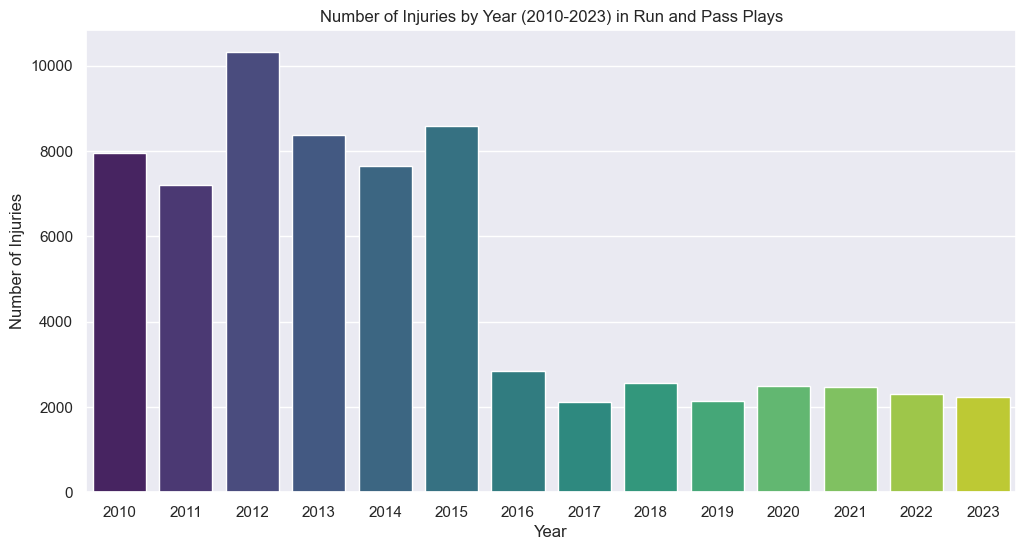

In [228]:
# Plot the injuries by year
injuries_by_year = combined_data.groupby('season_x')['injury'].sum()

plt.figure(figsize=(12, 6))
sns.barplot(x=injuries_by_year.index, y=injuries_by_year.values, palette='viridis')
plt.title('Number of Injuries by Year (2010-2023) in Run and Pass Plays')
plt.xlabel('Year')
plt.ylabel('Number of Injuries')
plt.savefig('../visualizations/injuries_by_year.png')
plt.show()

/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_55120/3365138899.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=injuries_by_surface.index, y=injuries_by_surface.values, palette='viridis')


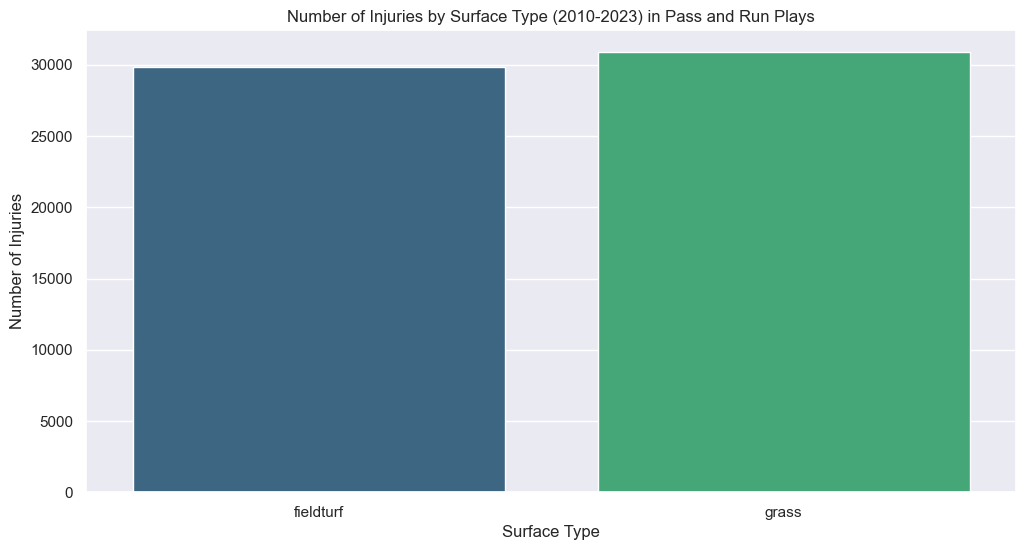

In [229]:
# Plot injuries by field type
injuries_by_surface = combined_data.groupby('surface')['injury'].sum()
plt.figure(figsize=(12, 6))
sns.barplot(x=injuries_by_surface.index, y=injuries_by_surface.values, palette='viridis')
plt.title('Number of Injuries by Surface Type (2010-2023) in Pass and Run Plays')
plt.xlabel('Surface Type')
plt.ylabel('Number of Injuries')
plt.savefig('../visualizations/injuries_by_surface.png')
plt.show()

/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_55120/1124180181.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=injuries_by_body_part.values, y=injuries_by_body_part.index, palette='viridis', orient='horizontal')


Text(54.624999999999986, 0.5, 'Body Part')

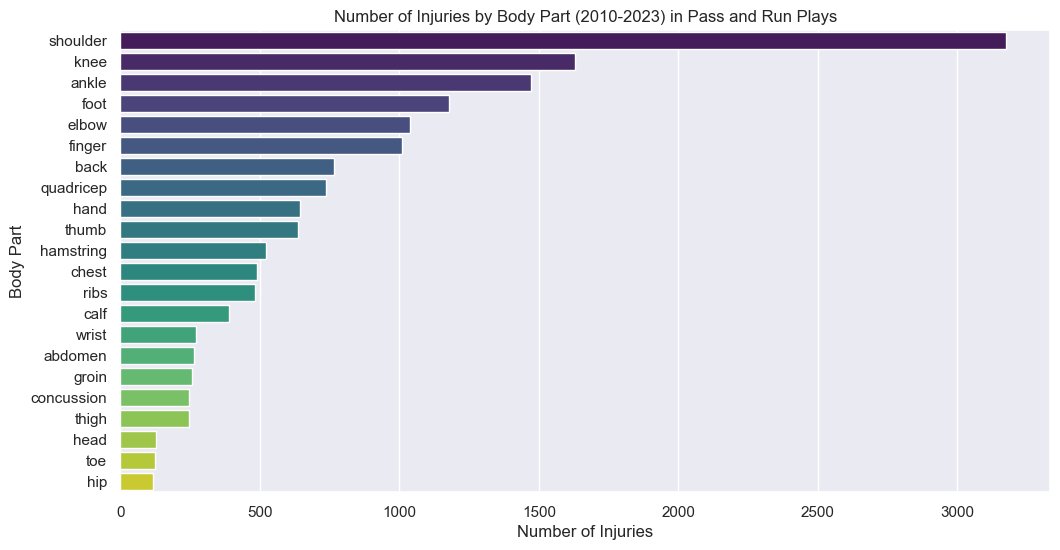

In [230]:
# Plot injuries by body part

# Exclude 'No injury' from the data and calculate the number of injuries by body part
injuries_by_body_part = combined_data[combined_data['final_injury_part'] != 'No injury'].groupby('final_injury_part')['injury'].sum()
injuries_by_body_part = injuries_by_body_part.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=injuries_by_body_part.values, y=injuries_by_body_part.index, palette='viridis', orient='horizontal')
plt.title('Number of Injuries by Body Part (2010-2023) in Pass and Run Plays')
plt.xlabel('Number of Injuries')
plt.savefig('../visualizations/injuries_by_body_part.png', dpi=300, bbox_inches='tight')
plt.ylabel('Body Part')

## Data Selection

In [231]:
# This will be our target variable
y = combined_data['injury']

In [232]:
# Drop all the columns that we don't want to use for training, more will be discarded later
training = combined_data.drop(columns=['play_id', 'game_id', 'week', 'season_x', 'away_team', 'home_team', 'injury_body_part_passer',
       'injury_body_part_receiver', 'injury_body_part_rusher', 'old_game_id', 'gsis', 'nfl_detail_id', 'pfr', 'pff',
       'espn', 'ftn', 'away_moneyline',
       'home_moneyline', 'spread_line', 'away_spread_odds', 'home_spread_odds',
       'total_line', 'under_odds', 'over_odds', 'away_qb_id', 'home_qb_id', 'away_qb_name',
       'home_qb_name', 'away_coach', 'home_coach', 'referee', 'stadium_id', 'stadium', 'passer_player_id',
       'passer_player_name', 'receiver_player_id', 'receiver_player_name', 'rusher_player_id', 'rusher_player_name']).copy()

In [233]:
# Classify the columns into numerical and categorical for encoding and scaling

training_numeric_cols = training.select_dtypes(include=[np.number]).columns.tolist()
training_numeric = training[training_numeric_cols]
training_categorical_cols = training.select_dtypes(include=['object']).columns.tolist()
training_categorical = training[training_categorical_cols]

In [234]:
print(f"Numeric columns: {training_numeric_cols}")
print(f"Categorical columns: {training_categorical_cols}")

Numeric columns: ['quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'qtr', 'down', 'ydstogo', 'yardline_100', 'score_differential', 'rush_attempt', 'pass_attempt', 'sack', 'incomplete_pass', 'qb_scramble', 'shotgun', 'no_huddle', 'qb_dropback', 'air_yards', 'yards_after_catch', 'passing_yards', 'complete_pass', 'rushing_yards', 'yards_gained', 'epa', 'air_epa', 'yac_epa', 'rush_touchdown', 'pass_touchdown', 'first_down_rush', 'first_down_pass', 'season_y', 'away_score', 'home_score', 'result', 'total', 'overtime', 'away_rest', 'home_rest', 'div_game', 'temp', 'wind']
Categorical columns: ['play_type', 'pass_length', 'pass_location', 'run_location', 'run_gap', 'severity_passer', 'severity_receiver', 'severity_rusher', 'final_injury_part', 'severity', 'game_type', 'gameday', 'weekday', 'gametime', 'location', 'roof', 'surface']


## Model Training and Evaluation

### Data encoding

In [235]:
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

pca = PCA()
le = LabelEncoder()
scaler = StandardScaler()
pipeline = make_pipeline(scaler, pca) 

for feat in training_categorical_cols:
    training_categorical[feat] = le.fit_transform(training_categorical[feat].astype(str))

for feat in training_numeric_cols:
    training_numeric[feat].fillna(training_numeric[feat].mean(), inplace=True)

/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_55120/1271475230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_categorical[feat] = le.fit_transform(training_categorical[feat].astype(str))
/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_55120/1271475230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_categorical[feat] = le.fit_transform(training_categorical[feat].astype(str))
/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_55120/1271475230.py:12:

Encode both categorical and numerical variables

In [236]:
training_data = pd.concat([training_numeric, training_categorical], axis=1)

In [237]:
X_enc = pipeline.fit_transform(training_data)

### Information gain

In [238]:
from sklearn.feature_selection import mutual_info_classif

ig = mutual_info_classif(X_enc, y, random_state=42)
ig

array([3.82796724e-04, 2.00428165e-02, 0.00000000e+00, 1.82130806e-03,
       9.43813006e-02, 4.71928413e-05, 1.52688233e-03, 1.30849751e-03,
       2.97785506e-03, 2.24715726e-02, 1.93189308e-04, 6.47837917e-03,
       7.41833619e-04, 0.00000000e+00, 6.46596646e-04, 2.34680406e-02,
       8.58945556e-03, 6.12634923e-03, 2.39067602e-02, 5.82414619e-02,
       2.26003870e-02, 5.43507281e-02, 5.42935506e-02, 1.45791889e-01,
       9.84051308e-03, 2.08116290e-02, 8.28230456e-02, 2.69259682e-04,
       0.00000000e+00, 2.91521641e-03, 2.21962875e-04, 1.90132715e-02,
       1.77472776e-04, 4.82945190e-03, 9.29271517e-04, 6.01583042e-05,
       6.60434707e-04, 2.82677166e-04, 5.03866685e-03, 1.11965147e-04,
       2.22864780e-05, 0.00000000e+00, 9.38946028e-02, 4.20912926e-02,
       0.00000000e+00, 2.29873420e-02, 0.00000000e+00, 1.89540749e-04,
       1.23177509e-02, 4.50813553e-05, 1.71128624e-04, 3.89418508e-03,
       2.85530165e-03, 3.62175819e-03, 3.73000858e-03, 9.20188194e-03,
      

In [239]:
# Create a dictionary to store the feature and its information gain
ig_dict = {}
for i in range(len(training_data.columns)):
    ig_dict[training_data.columns[i]] = ig[i]

In [240]:
ig_dict_sorted = dict(sorted(ig_dict.items(), key=lambda item: item[1], reverse=True))

# Select the top n features with the highest information gain for training the model
n = 20
selected_features = list(ig_dict_sorted.keys())[:n]

# Print the selected features
print('Selected Features:')
print(selected_features)

Selected Features:
['air_epa', 'down', 'pass_location', 'pass_touchdown', 'complete_pass', 'yards_gained', 'epa', 'run_location', 'passing_yards', 'qb_dropback', 'severity_passer', 'rushing_yards', 'pass_attempt', 'rush_touchdown', 'half_seconds_remaining', 'home_score', 'final_injury_part', 'yac_epa', 'roof', 'air_yards']


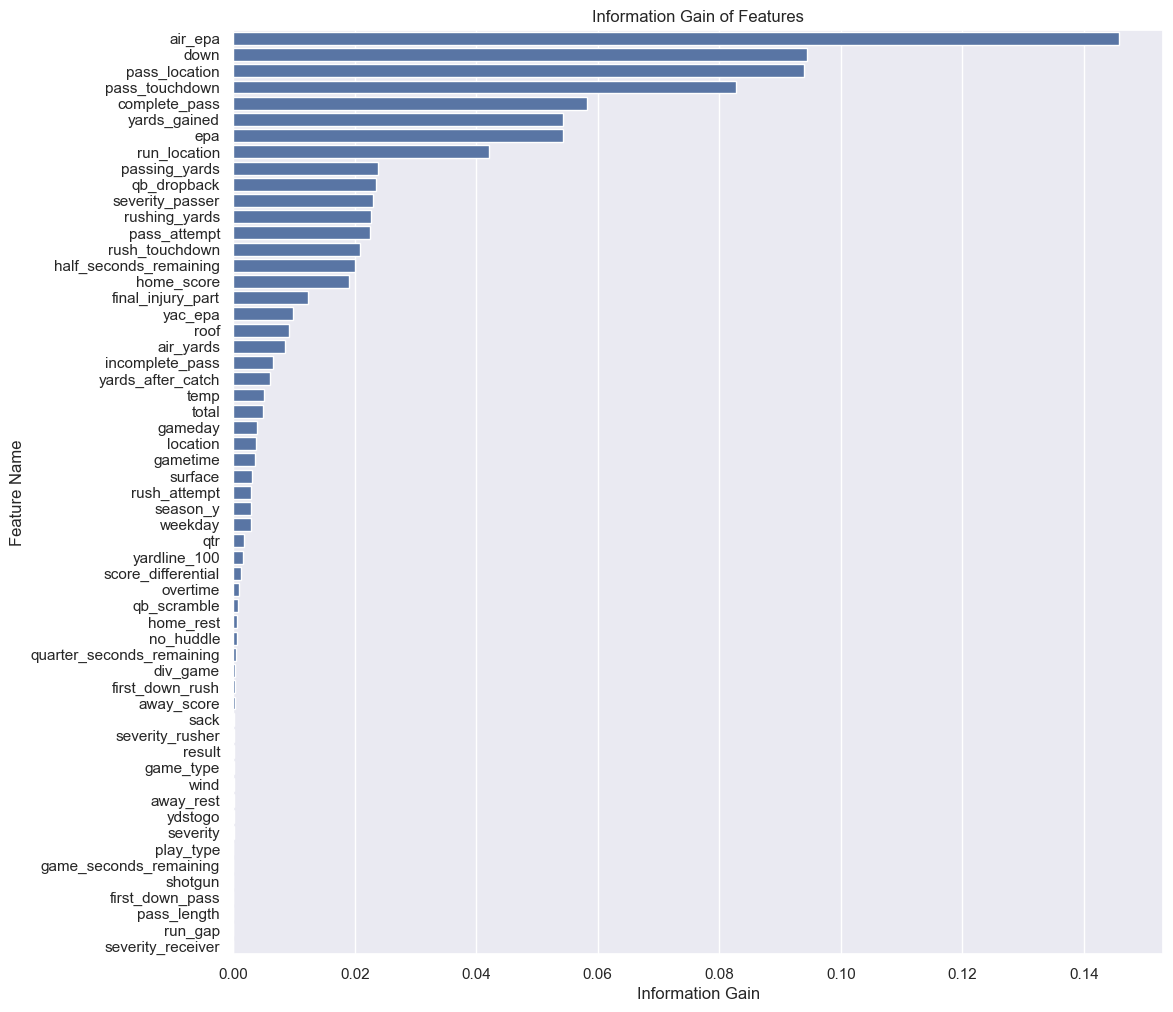

In [241]:
# Visualize the information gain of each feature
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,12)})
sns.barplot(x=list(ig_dict_sorted.values()), y=list(ig_dict_sorted.keys()))
plt.title('Information Gain of Features')
plt.xlabel('Information Gain')
plt.ylabel('Feature Name')
plt.savefig('../visualizations/information_gain.png')
plt.show()

### Model training

In [242]:
final_training = pd.DataFrame(
    data=X_enc, 
    index=training_data.index, 
    columns=training_data.columns
)

In [243]:
# Use only the selected features by the information gain
final_training = final_training[selected_features]

In [244]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final_training, y, test_size=0.2, random_state=41)

In [245]:
from sklearn.linear_model import LinearRegression

linr = LinearRegression()
linr.fit(X_train, y_train)

LinearRegression()

### Model testing and evaluation

R-squared: 0.87
Training Set: 0.8694782052874421
Test Set: 0.8703807450381872


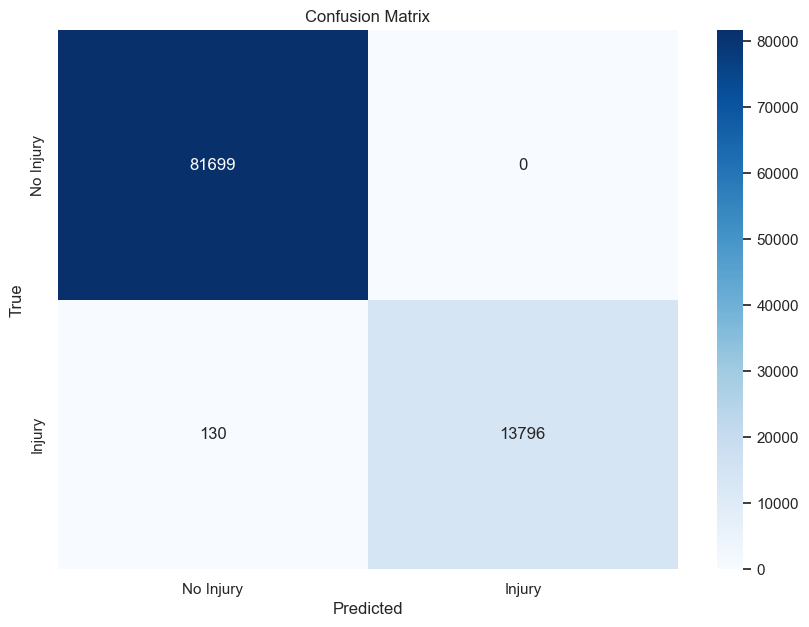

In [246]:
from sklearn.metrics import confusion_matrix

#See the R-Squared
score = linr.score(X_test, y_test)
print("R-squared: {:.2f}".format(score))

#Now test the model
y_pred = linr.predict(X_test)
print('Training Set:', linr.score(X_train,y_train))
print('Test Set:', linr.score(X_test,y_test))

# Convert continuous predictions to binary predictions using a threshold, otherwise the we would get a 3x3 matrix
# We are using 0.5 as the threshold, but it can be higher or lower
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate confusion matrix to evaluate the model performance and see how many injuries were predicted
cm = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Injury', 'Injury'], yticklabels=['No Injury', 'Injury'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('../visualizations/confusion_matrix.png')
plt.show()
